# Continuing after cleaning data

Here we explore the data indepth after cleaning up the data

In [10]:
import findspark
findspark.init('/home/ubuntu/spark-2.3.3-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession

In [11]:
spark = SparkSession.builder.appName('bib').getOrCreate()

In [12]:
dff = spark.read.csv('train.csv', header=True, inferSchema=True)

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql.functions import isnull, when, col, isnan, count
import matplotlib.pyplot as plt
from pyspark.sql.types import *
import datetime
from pyspark.sql.functions import year, month, dayofmonth, mean
import pyspark.sql.functions as F
# pd.set_option('display.max_rows', 500)
sns.set_style('darkgrid')

In [14]:
df = dff.sample(False, 0.3)
df = df.withColumn('month', month(df['timestamp']))
df = df.withColumn('year', year(df['timestamp']))
import pyspark.sql.functions as F
cols = [F.when(~F.col(x).isin('NULL','NA','NaN'),F.col(x)).alias(x) for x in df.columns]
df = df.select(*cols)

In [6]:
dfp = df.sample(False, 0.3).toPandas()

In [7]:
dfp1 = df.select([count(when(isnull(c),c)).alias(c) for c in df.columns]).toPandas()
dfp2 = dfp1.stack()

In [8]:
removelist = list(dfp2[dfp2>2000][0].index)
df = df.drop('max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state',
 'preschool_quota',
 'school_quota',
 'hospital_beds_raion',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500')

In [9]:
strlist = []
for l in range(len(df.columns)):
    if isinstance(df.schema.fields[l].dataType, StringType) == True:
        strlist.append(df.schema.names[l])

In [10]:
numbli = []
for l in strlist:
    if any(c.isnumeric() for c in df.select(l).limit(1).collect()[0][0]) == True:
        numbli.append(l)
    else:
        pass

In [11]:
dflist = list(set(df.columns)-set(strlist))
strlist1 = list(set(strlist) - set(numbli))
dfli = df.select(*dflist)
dfst = df.select(*strlist1)
dfnu = df.select(*numbli)

In [12]:
for l in numbli:
    dfnu = dfnu.withColumn(l +'_int', dfnu[l].cast(FloatType()))

dfnu = dfnu.drop(*numbli)

In [13]:
from pyspark.sql.functions import monotonically_increasing_id 

In [14]:
dfli = dfli.withColumn("id",monotonically_increasing_id())
dfnu = dfnu.withColumn("id",monotonically_increasing_id())
dfst = dfst.withColumn("id",monotonically_increasing_id())

In [15]:
df2 = dfli.join(dfnu,'id', 'inner')
df2= df2.join(dfst, 'id','inner')
df2 = df2.drop('id')

In [16]:
li2 = df2.select([count(when(isnull(c),c)).alias(c) for c in df2.columns]).toPandas()
li3 = li2.stack()
li4 = list(li3[li3 > 0 ][0].index)

In [17]:
from pyspark.ml.feature import Imputer

In [18]:
li5 = []
for l in li4:
    li5.append(l+'_11')

In [19]:
imputer = Imputer(inputCols=li4, outputCols=li5)

In [20]:
df3 = imputer.setStrategy('median').setMissingValue(1.0).fit(df2).transform(df2)
df3 = df3.drop(*li4)

# Start Here

In [21]:
dffspk = df3.sample(0.3, False)
dff = dffspk.toPandas()
dfflist = list(dff.columns)

In [23]:
dffspk.count()

2746

In [31]:
dffspk.printSchema()

root
 |-- children_preschool: integer (nullable = true)
 |-- cafe_count_1500: integer (nullable = true)
 |-- prom_part_3000: double (nullable = true)
 |-- office_count_2000: integer (nullable = true)
 |-- market_count_3000: integer (nullable = true)
 |-- office_count_5000: integer (nullable = true)
 |-- big_road2_km: double (nullable = true)
 |-- prom_part_1000: double (nullable = true)
 |-- cafe_count_500_price_1000: integer (nullable = true)
 |-- big_church_count_1500: integer (nullable = true)
 |-- green_part_1000: double (nullable = true)
 |-- prom_part_1500: double (nullable = true)
 |-- 7_14_male: integer (nullable = true)
 |-- sport_count_3000: integer (nullable = true)
 |-- green_part_3000: double (nullable = true)
 |-- detention_facility_km: double (nullable = true)
 |-- green_part_1500: double (nullable = true)
 |-- cafe_count_5000_price_1000: integer (nullable = true)
 |-- basketball_km: double (nullable = true)
 |-- mosque_count_1500: integer (nullable = true)
 |-- shopping

## Log distribution of prices

The distribution appears to be gaussian in log scale. There appears to be a few outliers in the lower range, they could be special houses and does not have to fit into the overall profile of the housing data.

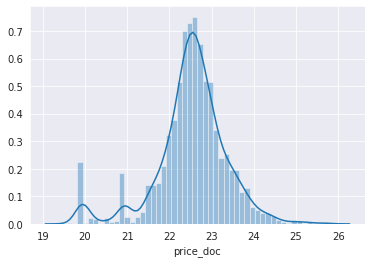

In [25]:
sns.distplot(np.log2(dff['price_doc']))

## Price distribution by product type (log scale)

The price distrubution is split into 2 types, Investment and Occupied. From the investment side it looks similar to the general distrubution with the 2 outliers which makes sense as they are probably used for a speical purpose. For the Occupied distribution the profile have the eneral gaussian profile only, meaning the outliers are investment properties.

In [22]:
dff['product_type'].unique()

array(['Investment', 'OwnerOccupier'], dtype=object)

In [23]:
ii = dff[['product_type','price_doc']]
i1 = ii[ii['product_type']=='Investment']
i2 = ii[ii['product_type']=='OwnerOccupier']

Investment


(13, 18)

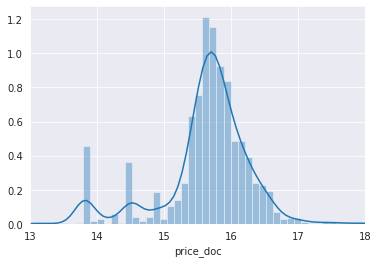

In [24]:
print('Investment')
ax = sns.distplot(np.log(i1['price_doc']))
ax.set_xlim(13,18)

OwnerOccupier


(13, 18)

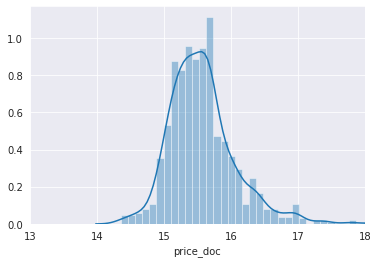

In [25]:
print('OwnerOccupier')
ax = sns.distplot(np.log(i2['price_doc']))
ax.set_xlim(13,18)

# Price over the years, avg in months

## Amount of Sales over time

In 12' ,13' , and 15' the count sales averaged around 50-60. There appears to be a selling boom or buyer's market which peaked at the end of 2014.

In [111]:
yi = dffspk.select('year').distinct().toPandas().sort_values(by=['year'])
y= list(yi['year'])

In [112]:
ii = dffspk.filter(F.col('year') == 2011).groupBy('month').count().toPandas()

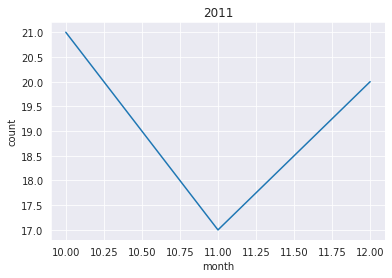

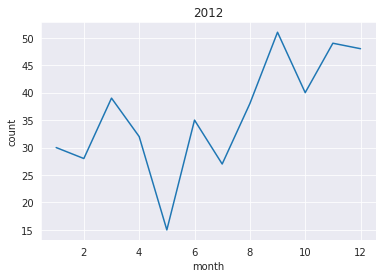

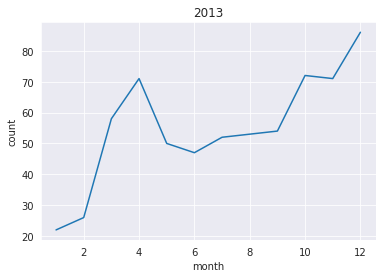

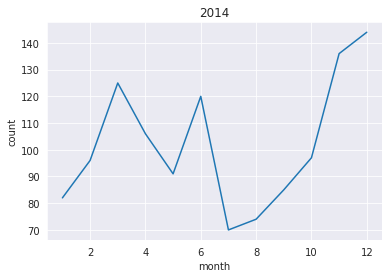

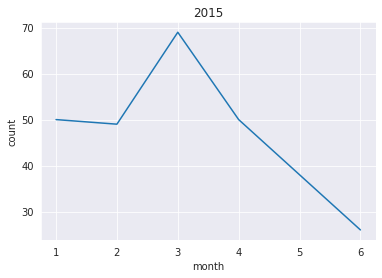

In [114]:
for i in y:
    ii = dffspk.filter(F.col('year') == i).groupBy('month').count().toPandas()
    sns.lineplot(x='month',y='count',data=ii)
    plt.title(i)
    plt.show()

### Price increase over the years

Average price of the sees a small trend upward but not by a lot. There are occational spikes which could be due to outliers in the data where they pop up from time to time.

In [24]:
i = dffspk.groupby('timestamp').avg('price_doc').toPandas()

In [25]:
i = i[i['timestamp']>'2011-01-01']

(734289.0, 735872.0)

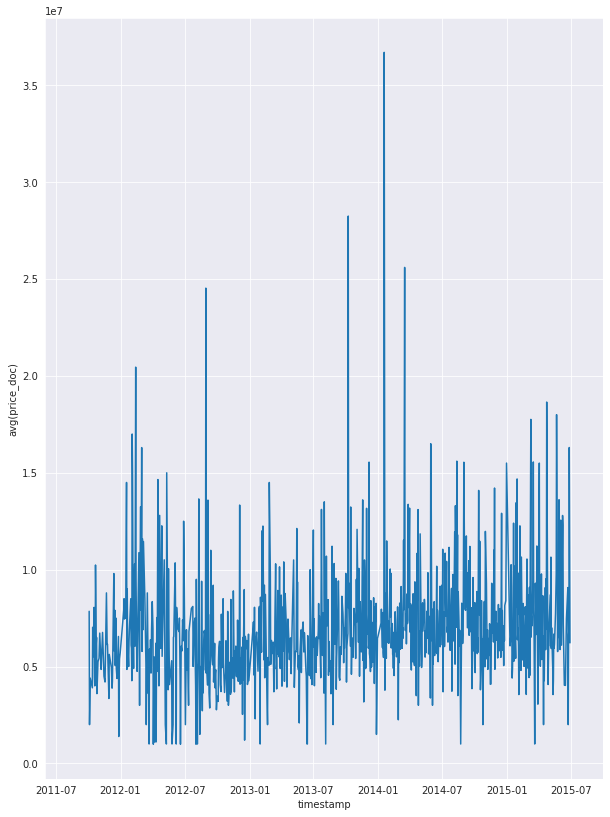

In [39]:
plt.figure(figsize=(10,14))
sns.lineplot(x='timestamp',y='avg(price_doc)',data=i)
plt.xlim('2011-06-01','2015-10-01')

In [35]:
from matplotlib import dates

i['timenumb']=i['timestamp'].apply(lambda x:x.strftime('%Y-%m-%d'))
i['time2']=dates.datestr2num(i['timenumb'])

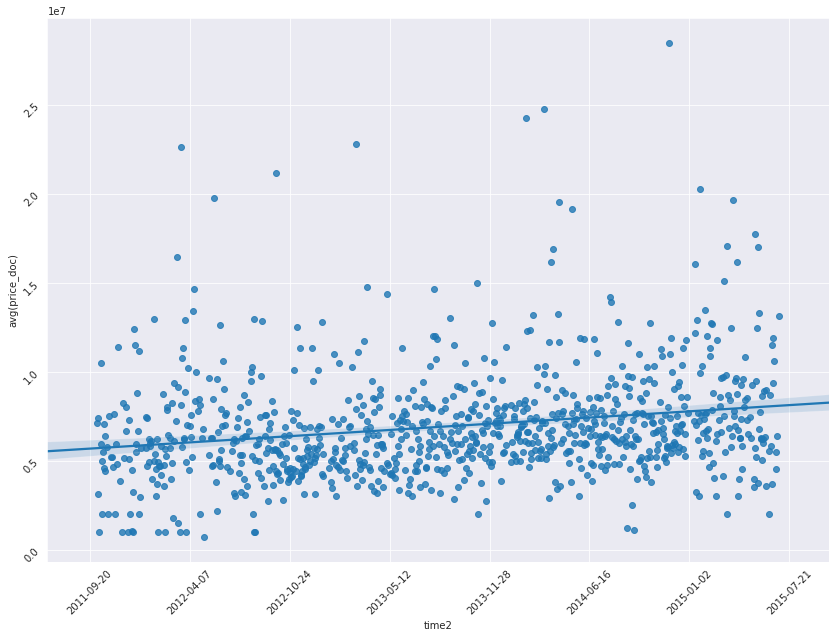

In [57]:
@plt.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 2016-05-08"""
    return dates.num2date(x).strftime('%Y-%m-%d')


fig, ax = plt.subplots( figsize=(14,10))

sns.regplot('time2', 'avg(price_doc)', data=i, ax=ax)
ax.xaxis.set_major_formatter(fake_dates)
ax.set_xlim([734315,735879])
ax.tick_params(labelrotation=45)

## Number of transaction over time

In [26]:
i = dffspk.groupby('timestamp').count().toPandas()

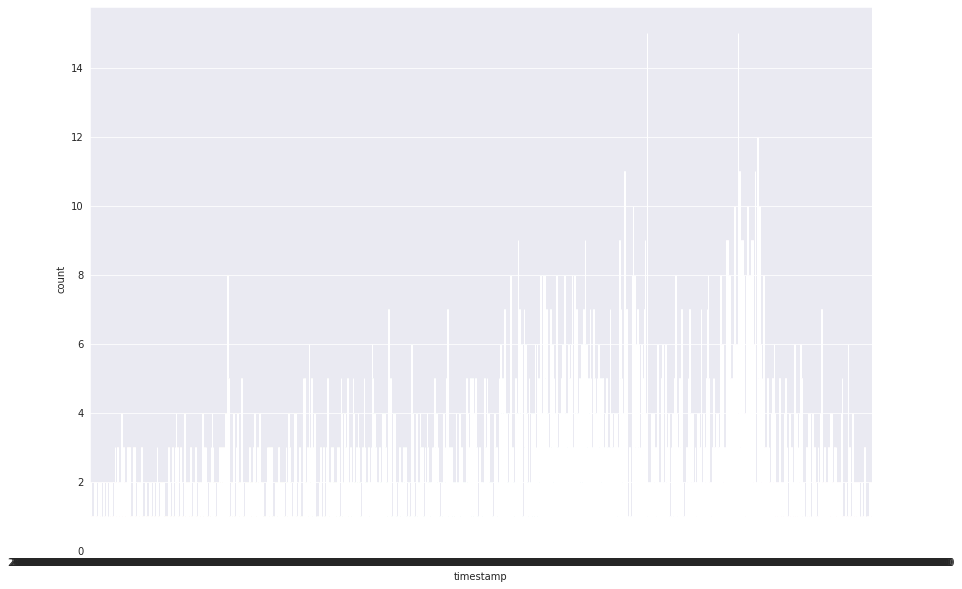

In [28]:
plt.figure(figsize=(14,10))
sns.barplot(x='timestamp',y='count',data=i)

## Avg price of floor

Average price based on floors. There doesnt seem to be an increase that much as the slope of the trend line is quite flat. 
As the floor goes higher the prices doesnt go up by that much but the price range does expand along with the increment floors. The highest price is at the highest floor at 31f. That flat could have a very good view since its price is beyond the norm.

In [23]:
i = dffspk.select(['floor_int_11','price_doc']).toPandas()

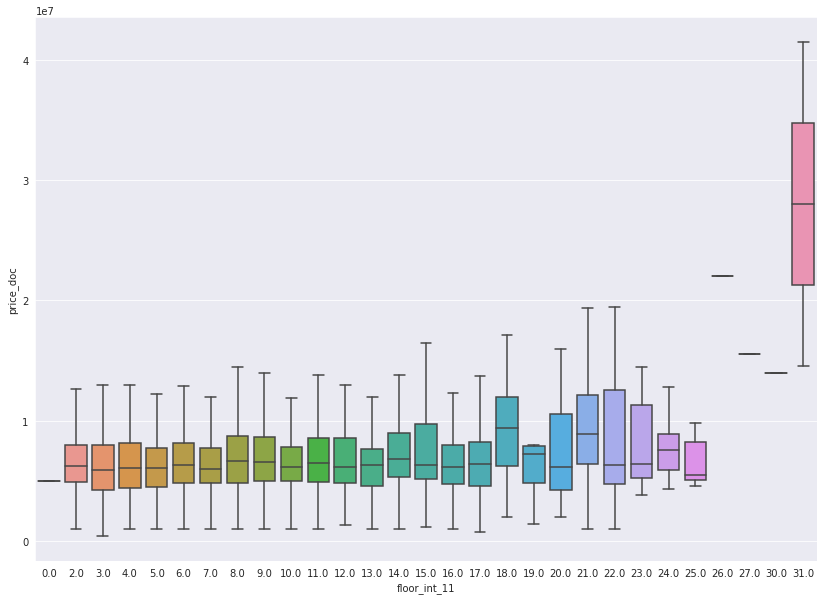

In [37]:
plt.figure(figsize=(14,10))
sns.boxplot(y='price_doc', x ='floor_int_11', data=i,showfliers=False)

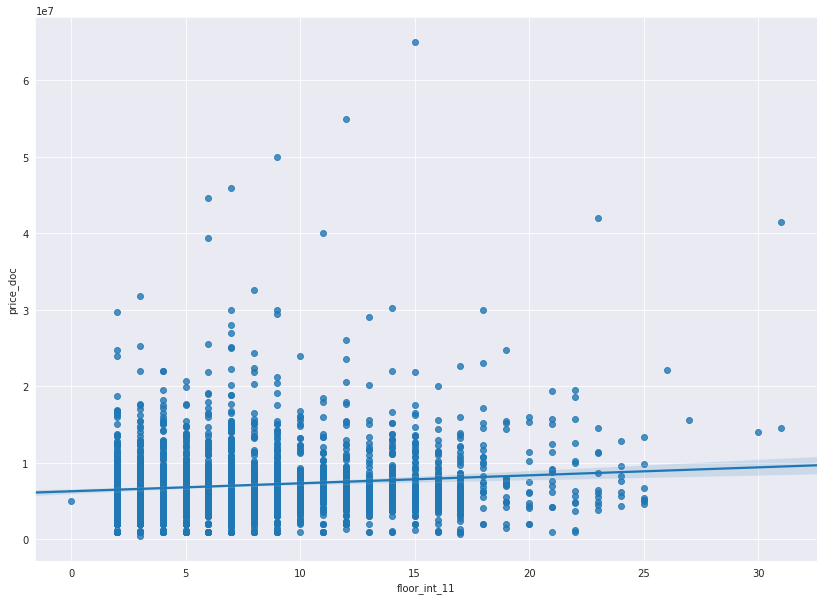

In [40]:
plt.figure(figsize=(14,10))
sns.regplot(x='floor_int_11',y='price_doc',data=i)

## Price of full_sq

Scatter plot along with a trend line with the price and full_sq. The price does indeed increase with square meter as expected.

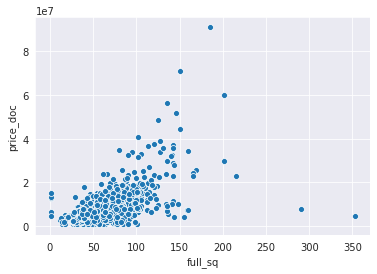

In [26]:
i = dffspk.select(['full_sq','price_doc']).toPandas()
sns.scatterplot(y='price_doc', x ='full_sq', data=i)

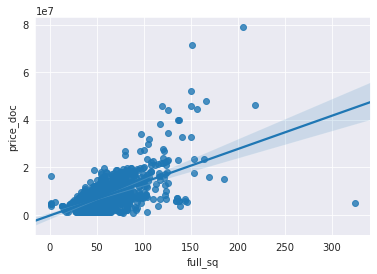

In [23]:
sns.regplot(y='price_doc', x ='full_sq', data=i)

Group by area

In [46]:
dffspk.select('sub_area').distinct().count()

143

In [30]:
suba = dffspk.groupby('sub_area').avg('price_doc')

In [31]:
suba = suba.toPandas()
suba = suba.sort_values(by=['avg(price_doc)'])

top and bottom 20 price list

In [26]:
subatop = list(suba['sub_area'].head(20))
subabot = list(suba['sub_area'].tail(20))

## Top 20 Avg Price by Area 

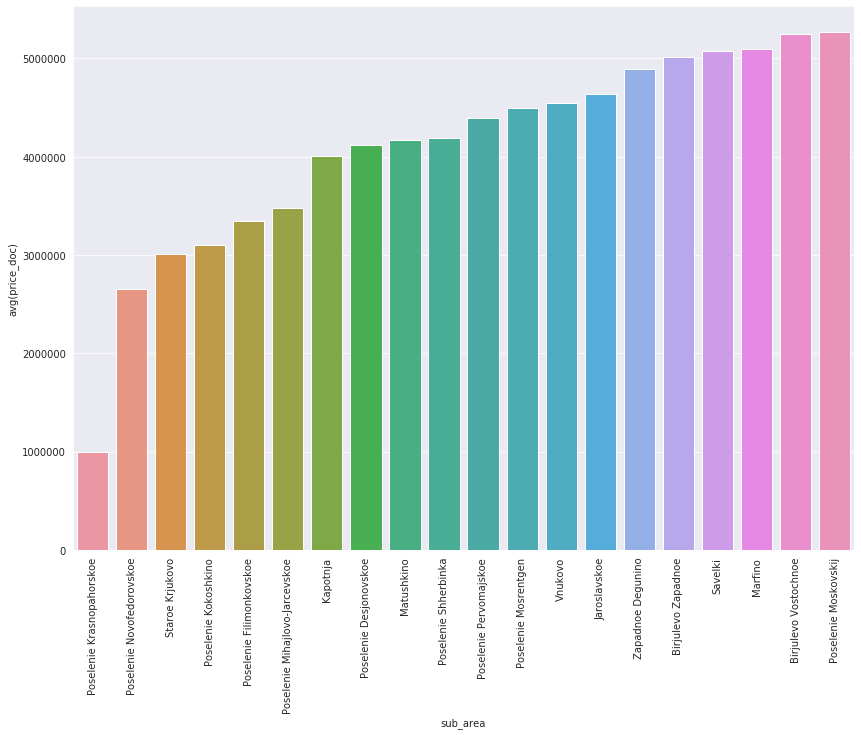

In [32]:
plt.figure(figsize=(14,10))
ax = sns.barplot(x='sub_area',y = 'avg(price_doc)',data= suba.head(20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

## Bottom 20 Avg Price by Area

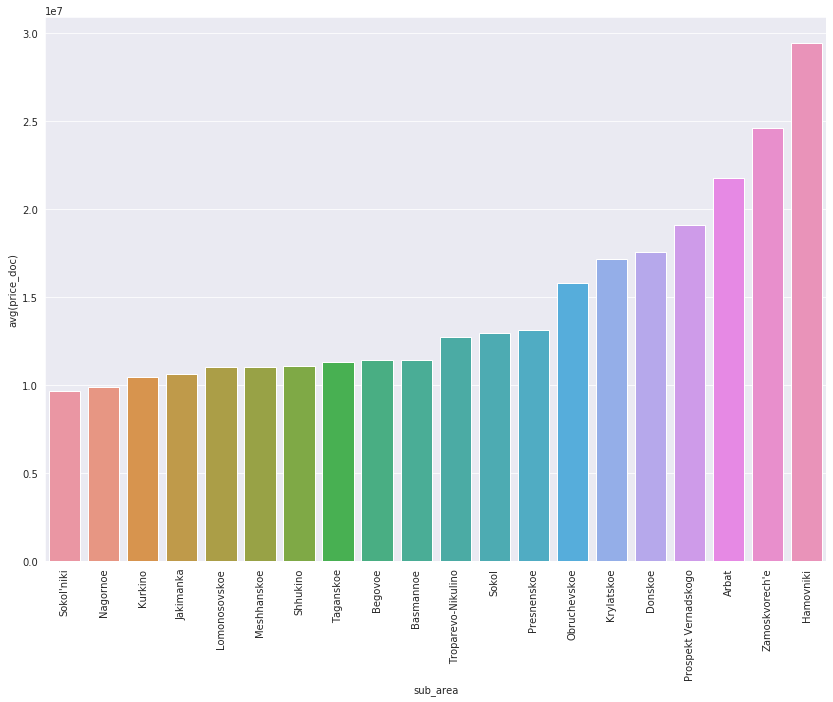

In [35]:
plt.figure(figsize=(14,10))
ax = sns.barplot(x='sub_area',y = 'avg(price_doc)',data= suba.tail(20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

## full_sq count

In [36]:
ii = dffspk.groupby('full_sq').count()

In [39]:
ii = ii.filter(F.col('count')>2).toPandas()

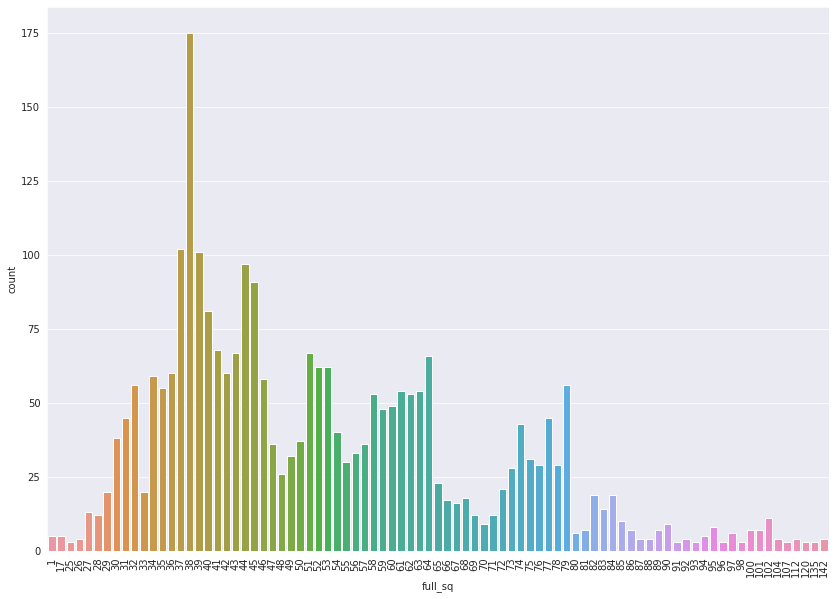

In [40]:
plt.figure(figsize=(14,10))
ax = sns.barplot(x='full_sq', y ='count', data=ii)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### Avg Price and Prices for floors

In [47]:
i = dffspk.groupby('floor_int_11').avg('price_doc').toPandas()

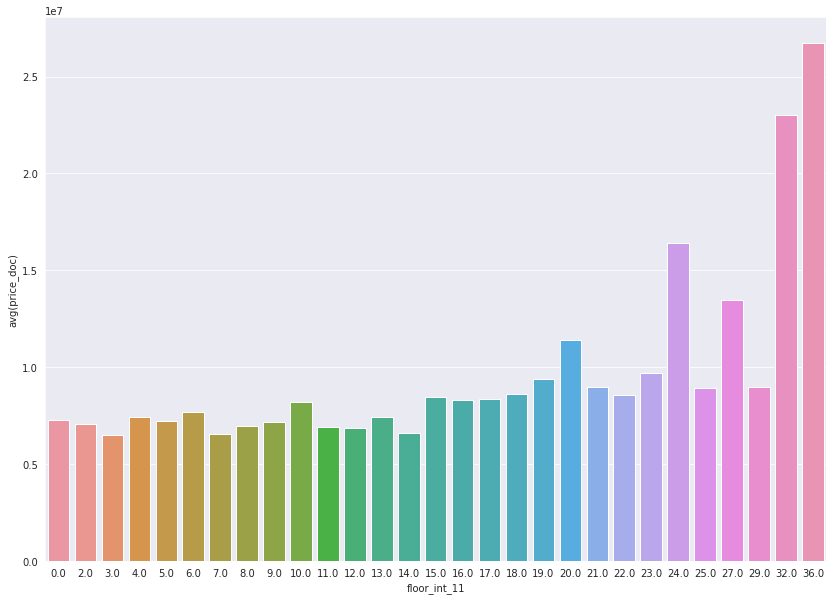

In [53]:
plt.figure(figsize=(14,10))
sns.barplot(x='floor_int_11',y='avg(price_doc)', data=i)

In [22]:
i = dff[['floor_int_11','price_doc']]

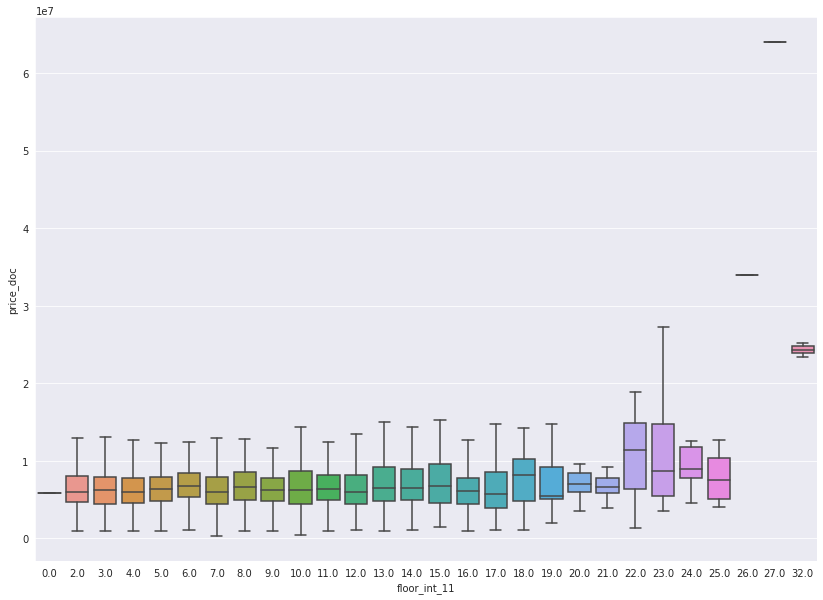

In [24]:
plt.figure(figsize=(14,10))
sns.boxplot(x='floor_int_11',y='price_doc',data=i,showfliers=False)

### Range of prices across the months of the whole DF

In [57]:
i = dff[['month','price_doc']]

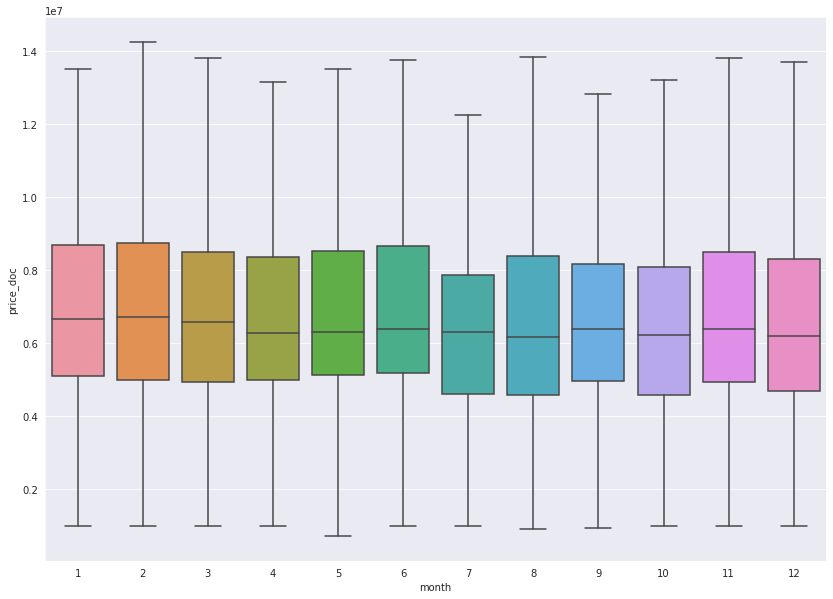

In [62]:
plt.figure(figsize=(14,10))
sns.boxplot(x='month',y='price_doc', data=i, showfliers=False)

## Sell counts per month of whole DF

In [64]:
ii = dffspk.groupby('month').count()

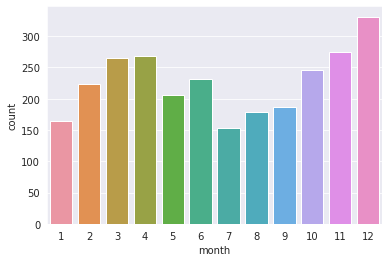

In [68]:
sns.barplot(x='month',y='count',data=ii.toPandas())

# Looking at the geographics

Schools, office, market, etc. Getting list first

In [22]:
l1 = list(filter(lambda k: 'school' in k.lower(), dfflist))
ed = list(filter(lambda k: 'education' in k.lower(), dfflist))
uni = list(filter(lambda k: 'university' in k.lower(), dfflist))
l1 = l1 + ed + uni

In [23]:
l1 = list(filter(lambda k: 'km' not in k.lower(), l1))
l1 = l1 + ['price_doc']

In [24]:
l2 = dff[l1]

In [51]:
l2.describe()

,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_top_20_raion,school_education_centers_raion,preschool_education_centers_raion,additional_education_raion,school_education_centers_top_20_raion,school_education_centers_raion,university_top_20_raion,price_doc
count,2734.000000,2734.000000,2734.000000,2734.000000,2734.000000,2734.000000,2734.000000,2734.000000,2734.000000,2734.000000,2.734000e+03
mean,5290.114850,4.133870,5524.958303,0.121800,4.826993,4.133870,3.004755,0.121800,4.826993,0.149963,7.203617e+06
std,3933.413386,3.041427,4094.388331,0.348769,3.499264,3.041427,3.500506,0.348769,3.499264,0.468751,4.869273e+06
min,175.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.506370e+05
25%,1908.000000,2.000000,1892.000000,0.000000,2.250000,2.000000,1.000000,0.000000,2.250000,0.000000,4.735838e+06
50%,4935.000000,4.000000,5469.000000,0.000000,5.000000,4.000000,2.000000,0.000000,5.000000,0.000000,6.300000e+06
75%,7116.000000,6.000000,7425.000000,0.000000,7.000000,6.000000,4.000000,0.000000,7.000000,0.000000,8.400000e+06
max,19223.000000,13.000000,19083.000000,2.000000,14.000000,13.000000,16.000000,2.000000,14.000000,3.000000,7.880225e+07


In [25]:
p = l2[['price_doc','university_top_20_raion']]

In [29]:
pi = p.copy()

In [30]:
pi['log_price'] = np.log(p['price_doc'])

In [31]:
p = pi[['log_price','university_top_20_raion']]

In [33]:
p.head()

,log_price,university_top_20_raion
0,15.390978,0
1,15.384126,0
2,15.520259,0
3,15.789592,0
4,14.547878,0


<Figure size 1008x720 with 0 Axes>

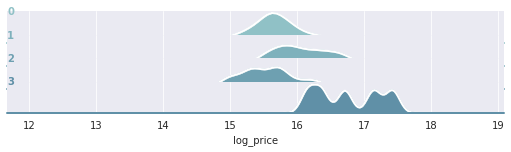

In [46]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
plt.figure(figsize=(14,10))
g = sns.FacetGrid(p, row="university_top_20_raion", hue="university_top_20_raion", aspect=15, height=.5, palette=pal)

g.map(sns.kdeplot, "log_price", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "log_price", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, 1, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "log_price")

g.fig.subplots_adjust(hspace=-.25)

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

# Demographics

kids, age, sex

In [66]:
malel = list(filter(lambda k: 'male' in k.lower(), dfflist))
malel = list(filter(lambda k: 'female' not in k.lower(), malel)) + ['price_doc']

In [67]:
femalel = list(filter(lambda k: 'female' in k.lower(), dfflist))+ ['price_doc']

In [68]:
all1 = list(filter(lambda k: 'all' in k.lower(), dfflist))
all1 = list(set(all1) -set(['basketball_km','basketball_km']))+ ['price_doc']

In [42]:
dff[malel].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0_13_male,2765.0,5.042098e+03,3.856979e+03,166.0,1600.0,4835.0,6684.0,18574.0
ekder_male,2765.0,5.749429e+03,4.039504e+03,156.0,1331.0,6180.0,8516.0,19275.0
male_f,2765.0,6.706777e+04,1.318046e+05,1264.0,12961.0,37959.0,58226.0,774585.0
work_male,2765.0,2.706489e+04,1.911234e+04,863.0,7394.0,26354.0,38841.0,79622.0
0_17_male,2765.0,6.426284e+03,4.887172e+03,214.0,1973.0,6065.0,8599.0,23233.0
young_male,2765.0,5.728610e+03,4.383490e+03,189.0,1782.0,5470.0,7597.0,20977.0
0_6_male,2765.0,2.633360e+03,2.022667e+03,91.0,862.0,2435.0,3598.0,9987.0
7_14_male,2765.0,2.746027e+03,2.107048e+03,87.0,821.0,2677.0,3585.0,9761.0
16_29_male,2765.0,1.535534e+04,2.980238e+04,308.0,2754.0,8734.0,13683.0,172958.0
price_doc,2765.0,7.064125e+06,4.481814e+06,190000.0,4750000.0,6300000.0,8189555.0,65000000.0


### Top 10 areas of males demographics, 0-17 , 16-29, and elder( >29)

In [26]:
ii = dff.groupby(['sub_area']).sum()[['0_17_male','work_male','16_29_male','ekder_male']]

### 

Text(0.5, 1.0, '0-17 Areas')

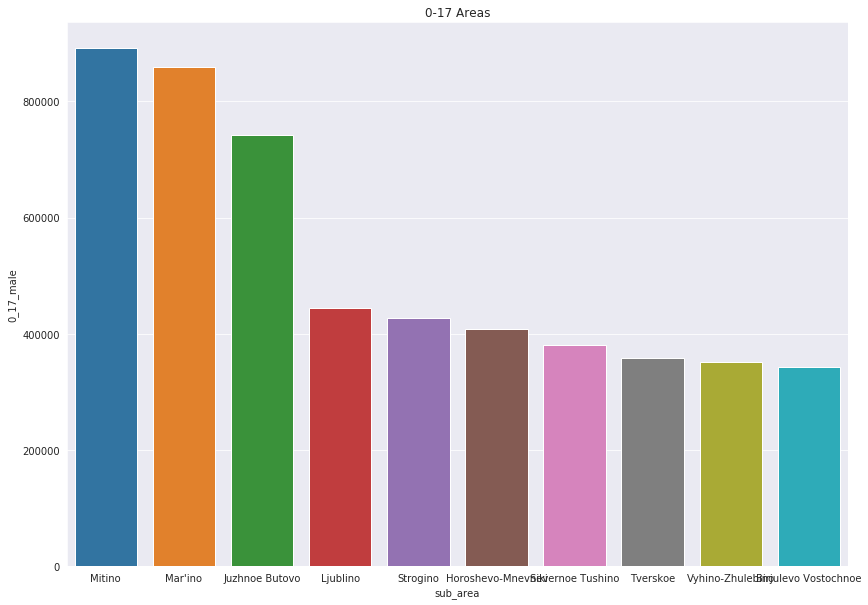

In [27]:
i1 = ii.sort_values('0_17_male', ascending=False).head(10)
plt.figure(figsize=(14,10))
sns.barplot(x=i1.index,y='0_17_male',data=i1).set_title('0-17 Areas')

Text(0.5, 1.0, '16-29 Areas')

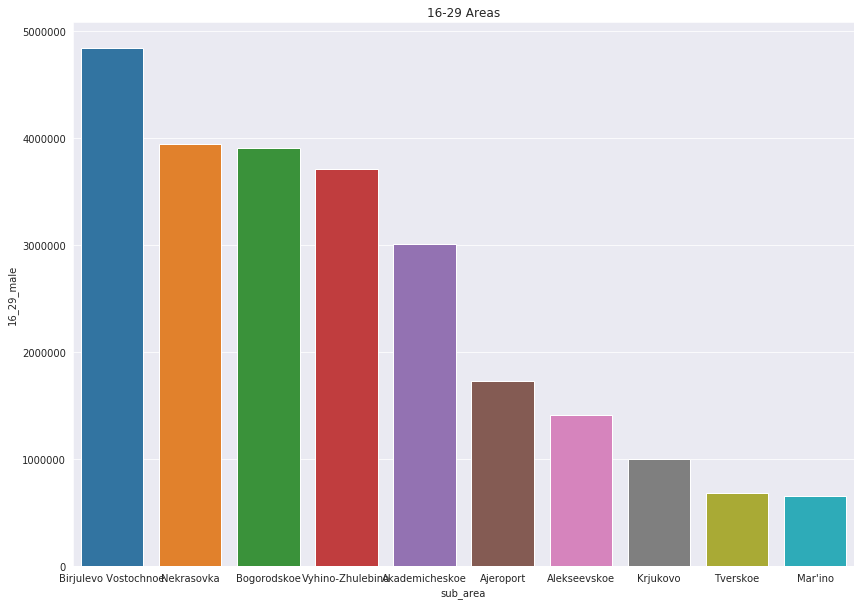

In [28]:
i1 = ii.sort_values('16_29_male', ascending=False).head(10)
plt.figure(figsize=(14,10))
sns.barplot(x=i1.index,y='16_29_male',data=i1).set_title('16-29 Areas')

Text(0.5, 1.0, 'Working Male Areas')

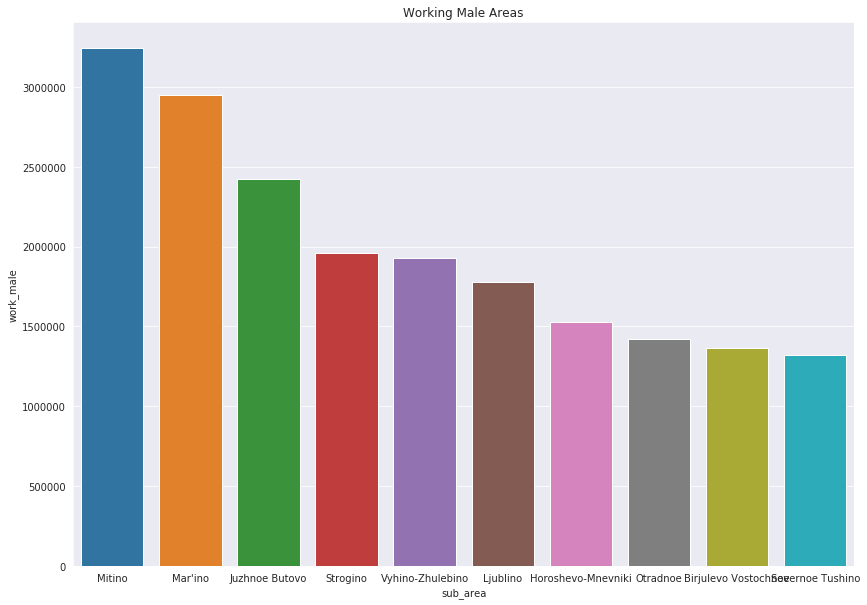

In [29]:
i1 = ii.sort_values('work_male', ascending=False).head(10)
plt.figure(figsize=(14,10))
sns.barplot(x=i1.index,y='work_male',data=i1).set_title('Working Male Areas')

Text(0.5, 1.0, 'Retired Male Areas')

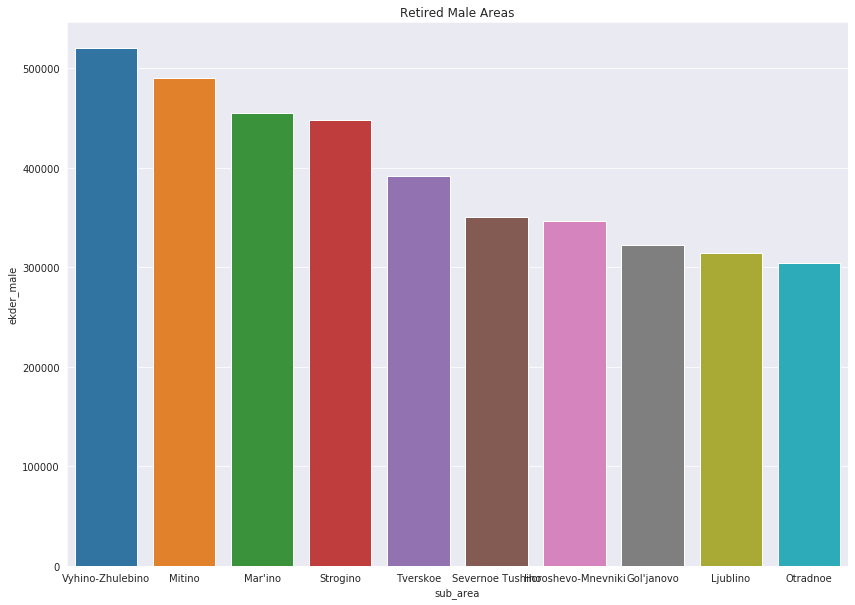

In [30]:
i1 = ii.sort_values('ekder_male', ascending=False).head(10)
plt.figure(figsize=(14,10))
sns.barplot(x=i1.index,y='ekder_male',data=i1).set_title('Retired Male Areas')

## Correlation between wokers and age

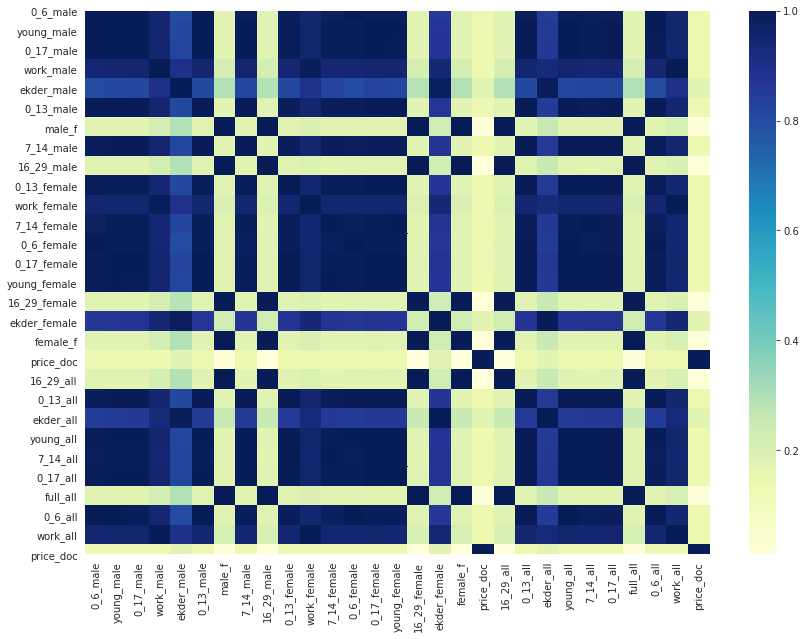

In [71]:
plt.figure(figsize=(14,10))
sns.heatmap(dff[ll].corr(),cmap="YlGnBu")

### Top 10 areas of females demographics, 0-17 , 16-29, elder( >29)

In [32]:
dff[femalel].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
16_29_female,2728.0,15292.289956,30093.722010,267.0,2593.0,8765.0,13919.0,194701.0
young_female,2728.0,5452.210777,3962.748522,177.0,1677.0,5340.0,7617.0,19715.0
7_14_female,2728.0,2606.550587,1913.160419,82.0,743.0,2545.0,3534.0,9322.0
0_6_female,2728.0,2509.631598,1818.194631,85.0,844.0,2390.0,3455.0,9236.0
0_13_female,2728.0,4799.354472,3483.269790,156.0,1512.0,4684.5,6721.0,17461.0
0_17_female,2728.0,6114.140762,4428.098091,198.0,1858.0,6321.0,8593.0,21937.0
ekder_female,2728.0,13389.186584,9114.059514,393.0,3365.0,13540.0,20165.0,37811.0
female_f,2728.0,76007.246334,148454.342183,1430.0,14780.0,45410.0,67872.0,942145.0
work_female,2728.0,26429.016129,18491.766142,771.0,6661.0,26333.0,37942.0,81668.0


In [32]:
ii = dff.groupby(['sub_area']).sum()[['0_17_female','work_female','16_29_female','ekder_female']]

Text(0.5, 1.0, '0-17 Areas')

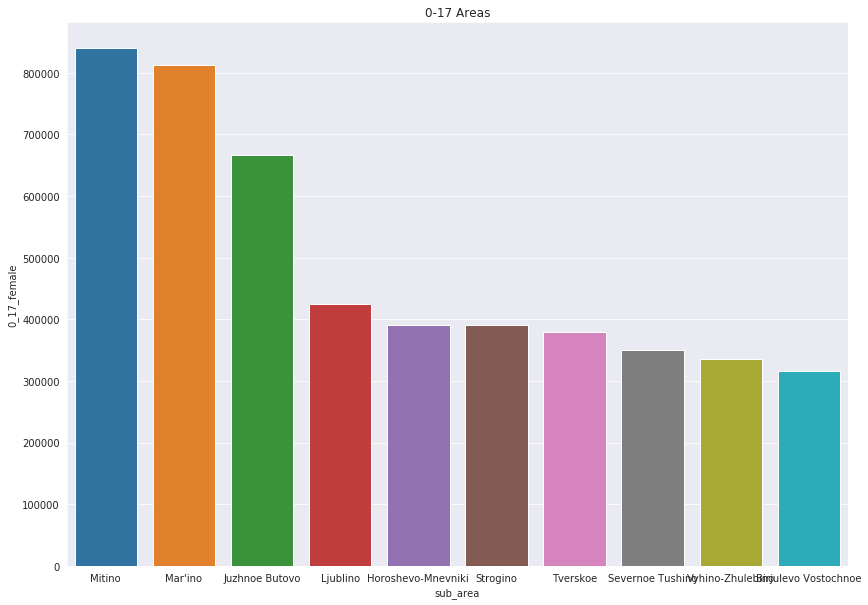

In [33]:
i1 = ii.sort_values('0_17_female', ascending=False).head(10)
plt.figure(figsize=(14,10))
sns.barplot(x=i1.index,y='0_17_female',data=i1).set_title('0-17 Areas')

Text(0.5, 1.0, '16-29 Areas')

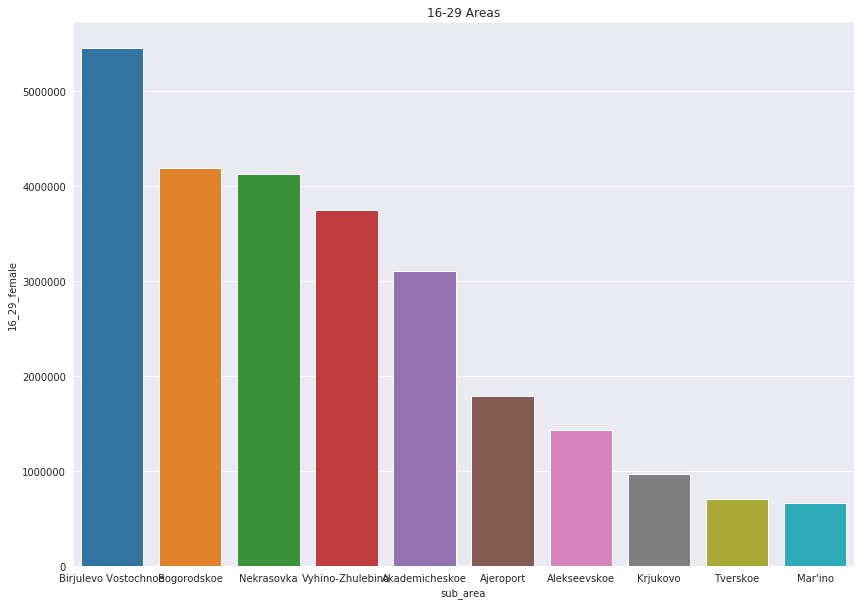

In [34]:
i1 = ii.sort_values('16_29_female', ascending=False).head(10)
plt.figure(figsize=(14,10))
sns.barplot(x=i1.index,y='16_29_female',data=i1).set_title('16-29 Areas')

Text(0.5, 1.0, 'Working Female Areas')

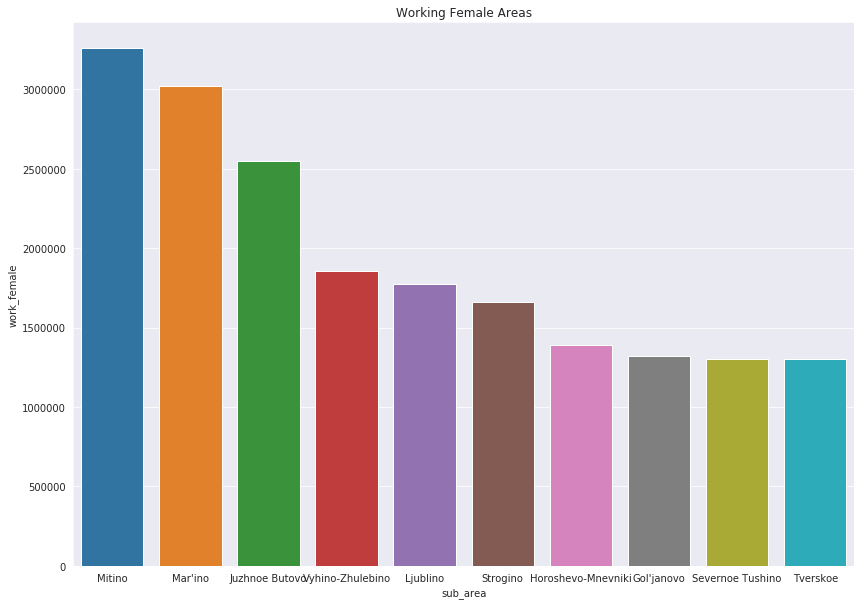

In [35]:
i1 = ii.sort_values('work_female', ascending=False).head(10)
plt.figure(figsize=(14,10))
sns.barplot(x=i1.index,y='work_female',data=i1).set_title('Working Female Areas')

Text(0.5, 1.0, 'Retired Female Areas')

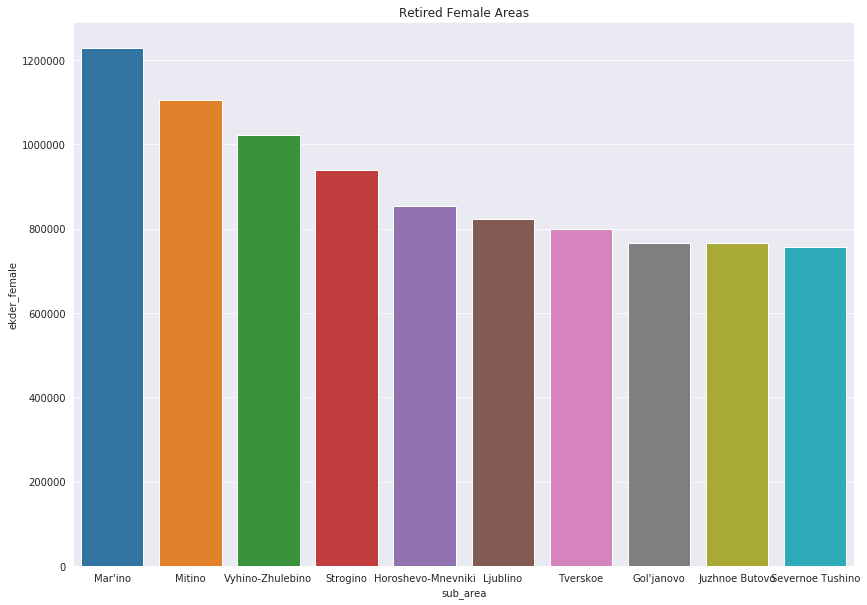

In [36]:
i1 = ii.sort_values('ekder_female', ascending=False).head(10)
plt.figure(figsize=(14,10))
sns.barplot(x=i1.index,y='ekder_female',data=i1).set_title('Retired Female Areas')

### Total population ratio 

In [46]:
ds = dff[all1].sum()
ds = ds[ds.index != 'full_all']
ds.drop('price_doc', axis=0, inplace=True)

In [47]:
ds

0_17_all      34702677
16_29_all     86650258
young_all     30946654
ekder_all     52669067
0_13_all      27248858
7_14_all      14824596
work_all     147372905
0_6_all       14231453
dtype: int64

In [27]:
nall1 = np.round(ds/sum(list(ds)),3)

In [28]:
labels = []
for n in ds.index: 
    labels.append(n + '  ' + str(np.round(nall1.loc[n] * 100,3)) + '%')

In [31]:
labels = list(ds.index)

In [32]:
labels

['0_17_all',
 '16_29_all',
 'young_all',
 'ekder_all',
 '0_13_all',
 '7_14_all',
 'work_all',
 '0_6_all']

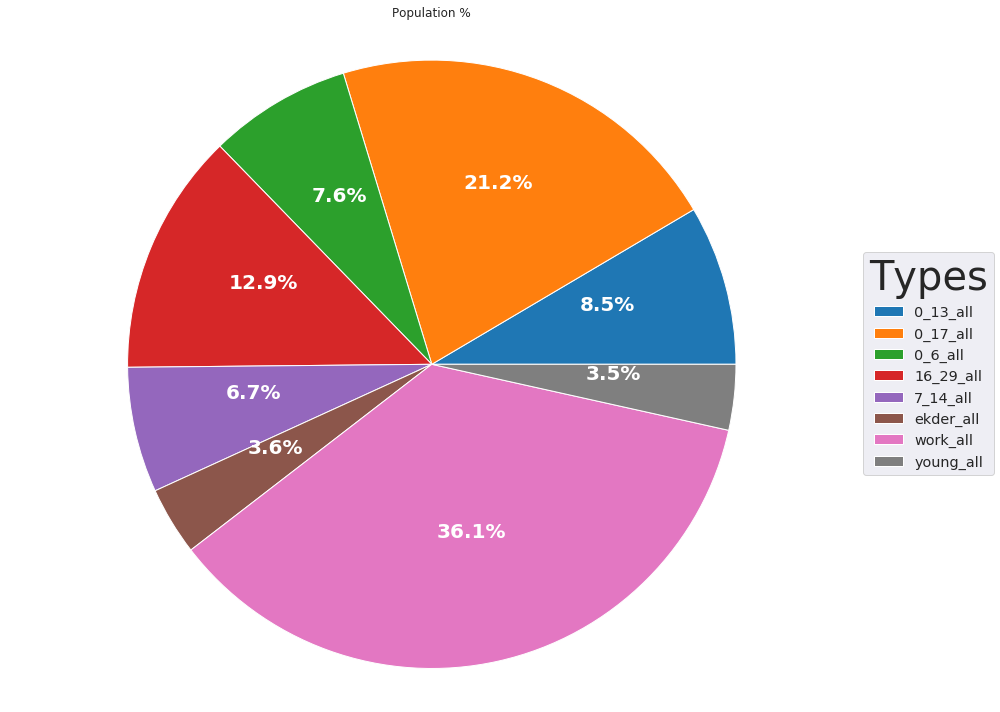

In [38]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

data = list(ds)
lab = ds.index.sort_values()

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, lab,
          title="Types",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize='x-large', title_fontsize='40',
             )

plt.setp(autotexts, size=20, weight="bold")
plt.axis('equal')

ax.set_title("Population %")
fig.set_size_inches(14,10)

plt.tight_layout()
plt.show()

# Interior

 floor, build_year, num_room, area_m, full_sq, life_sq, kitch_sq

In [100]:
ilist = ['floor', 'build_year', 'num_room', 'area_m', 'full_sq', 'life_sq', 'kitch_sq']
dfin = dfp[ilist]

### Distribution of number of floors

In [184]:
y =dfp['floor'].dropna().unique()

In [194]:
for x in range(0,len(y)): y[x] = int(y[x])
y.sort()
for x in range(0,len(y)): y[x] = str(y[x])

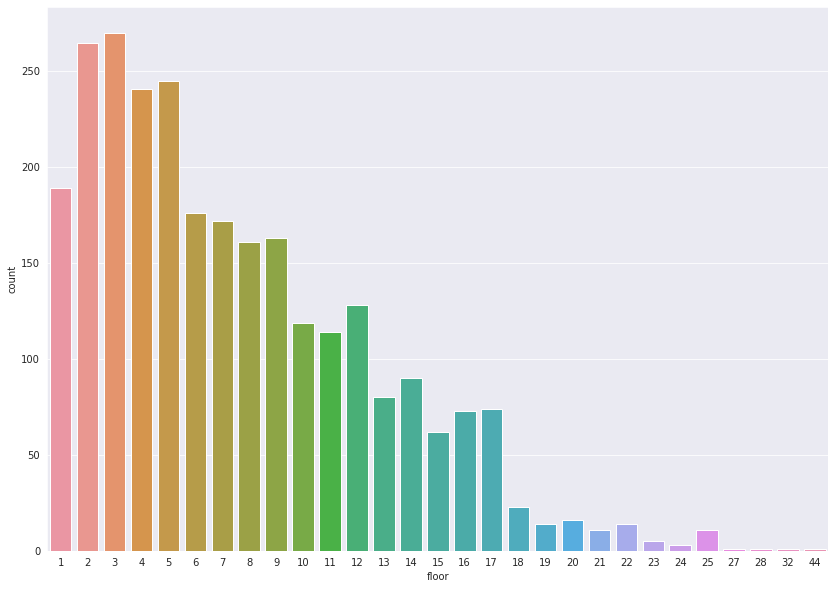

In [195]:
plt.figure(figsize=(14,10))
sns.countplot(dfp['floor'].sort_values().dropna(),
             order = y)


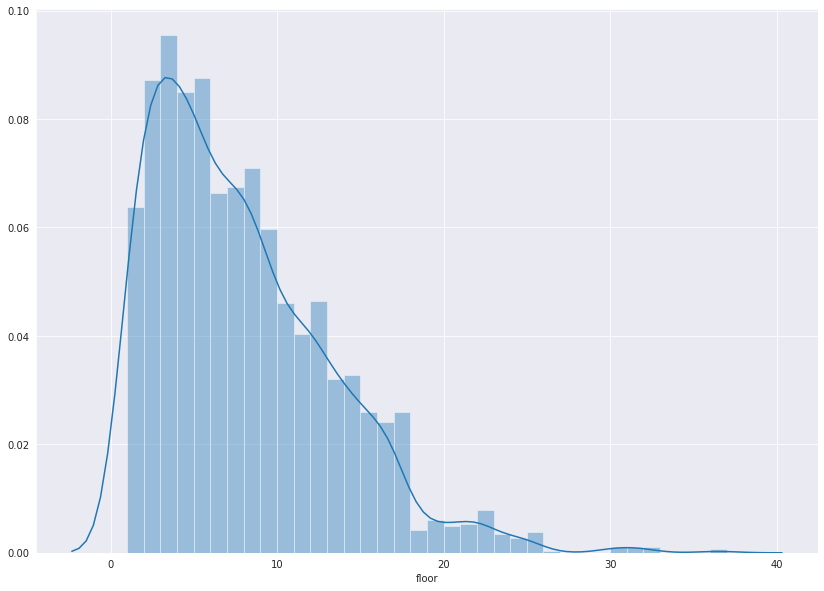

In [32]:
plt.figure(figsize=(14,10))
sns.distplot(dfp['floor'].dropna().astype('int32'))

### Year Built

In [36]:
y = dfp['build_year'].dropna()

(1940, 2019)

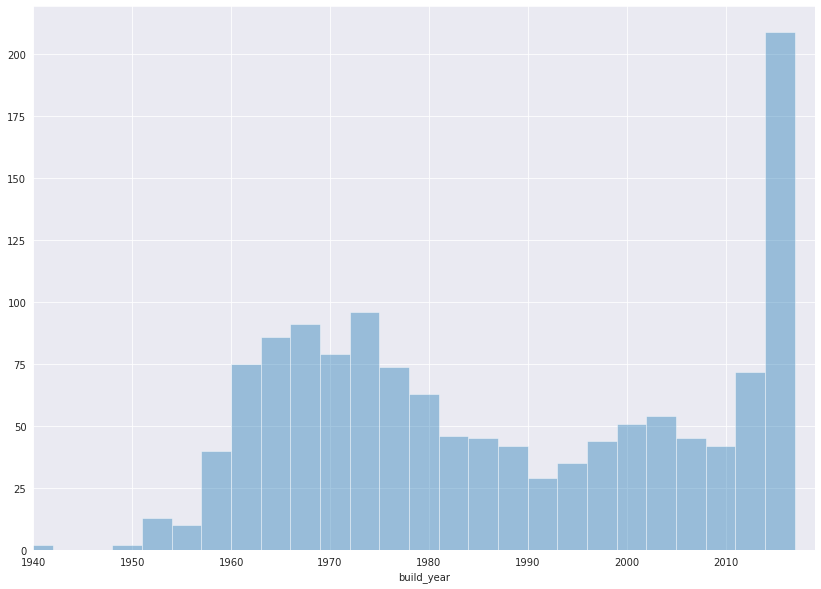

In [47]:
plt.figure(figsize=(14,10))
sns.distplot(y[y>1900],bins=30, kde=False)
plt.xlim(1940,2019)

### Mean price by year

In [22]:
y = dfp[['build_year','price_doc']].dropna()

In [95]:
yi = y.groupby('build_year').mean().iloc[2:]
yi.index = yi.index.astype('int32')
dfy = pd.DataFrame(dict(build_year=yi.index, price_doc=yi.values.flatten()))

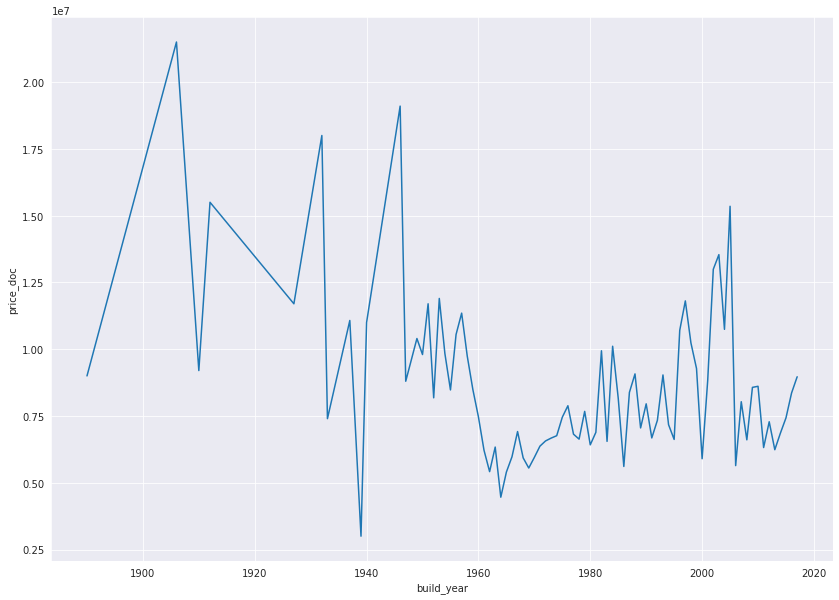

In [71]:
plt.figure(figsize=(14,10))
sns.lineplot(x=yi.index,y='price_doc',data=yi)

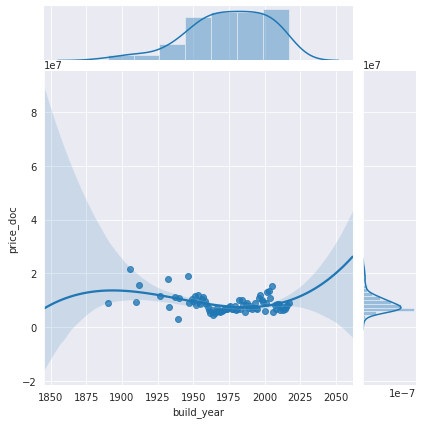

In [109]:
sns.jointplot(x='build_year',y='price_doc',data=dfy, kind='reg', order =3)

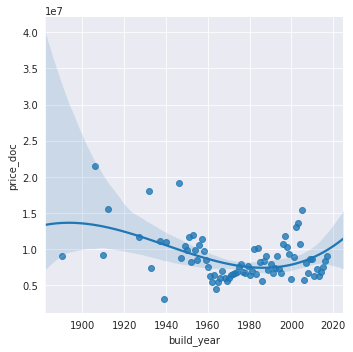

In [106]:
sns.lmplot(x='build_year',y='price_doc',data=dfy, order =3)

### Number of rooms

In [104]:
y =dfp['num_room'].dropna()
y = y[y!='0']

In [106]:
yi = y.value_counts()
yi

2    732
1    625
3    414
4     36
5      4
8      1
Name: num_room, dtype: int64

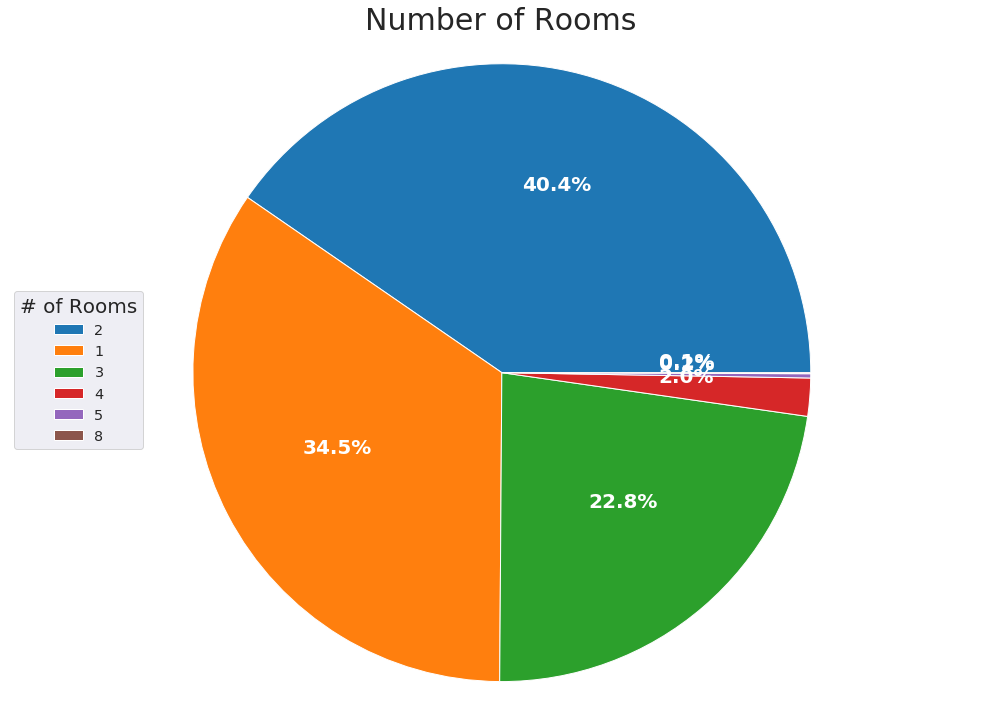

In [129]:
fig, ax = plt.subplots(figsize=(14,10), subplot_kw=dict(aspect='equal'))

data = list(yi)
lab = yi.index

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                 textprops=dict(color='w'))

ax.legend(wedges, lab,
         title='# of Rooms',
          loc ='center left',
          fontsize='x-large',
          title_fontsize='20'
         )

plt.setp(autotexts, size=20, weight='bold')
plt.axis('equal')

ax.set_title('Number of Rooms', fontsize=30)
fig.set_size_inches(14,10)

plt.tight_layout()
plt.show()

In [147]:
df1 = dfp['area_m'].dropna()
df2 = dfp['full_sq'].dropna()
df3 = dfp['life_sq'].dropna().astype('int32')
df4 = dfp['kitch_sq'].dropna().astype('int32')

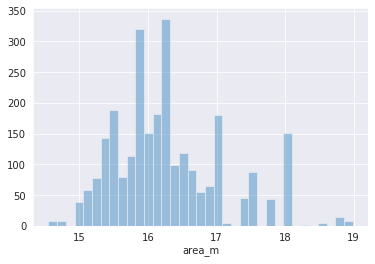

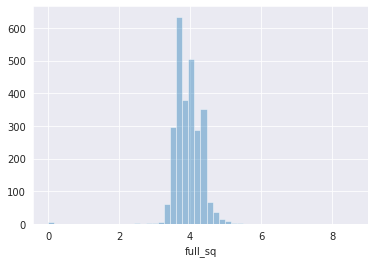

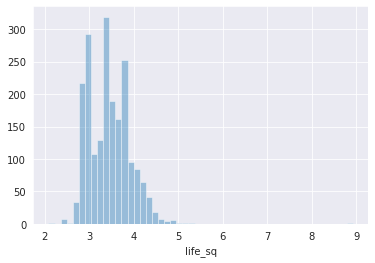

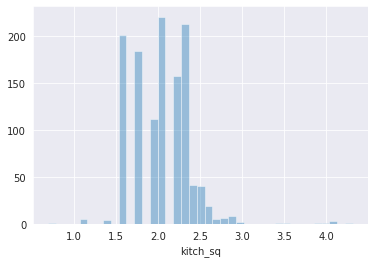

In [173]:
sns.distplot(np.log(df1),kde=False)
plt.show()
sns.distplot(np.log(df2),kde=False)
plt.show()
sns.distplot(np.log(df3[df3>1]),kde=False)
plt.show()
sns.distplot(np.log(df4[df4>1]),kde=False)
plt.show()

## Materials and price

In [26]:
i = dfp[['material','price_doc']].dropna()
i['price_doc'] = np.log(i['price_doc'])

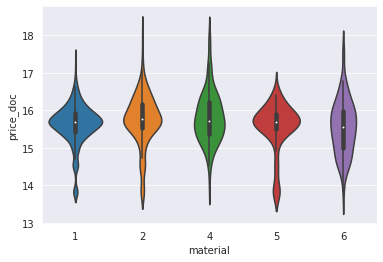

In [27]:
sns.violinplot(x='material',y='price_doc',data=i)

## State and price

In [32]:
i = dfp[['state','price_doc']].dropna()
i['price_doc'] = np.log(i['price_doc'])

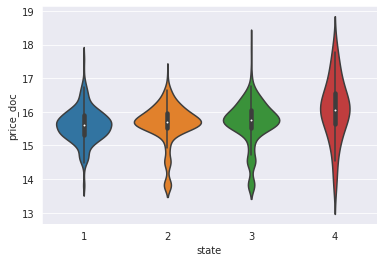

In [33]:
sns.violinplot(x='state',y='price_doc',data=i)

In [45]:
dffk = dff.copy()

In [46]:
dffk = dffk[['price_doc','cafe_count_3000']]

In [47]:
dffk['price_doc'] = np.log(dffk['price_doc'])

In [49]:
dffk['price_doc'] = np.round(dffk['price_doc'],1)

In [53]:
i=dffk.groupby(['price_doc']).mean()

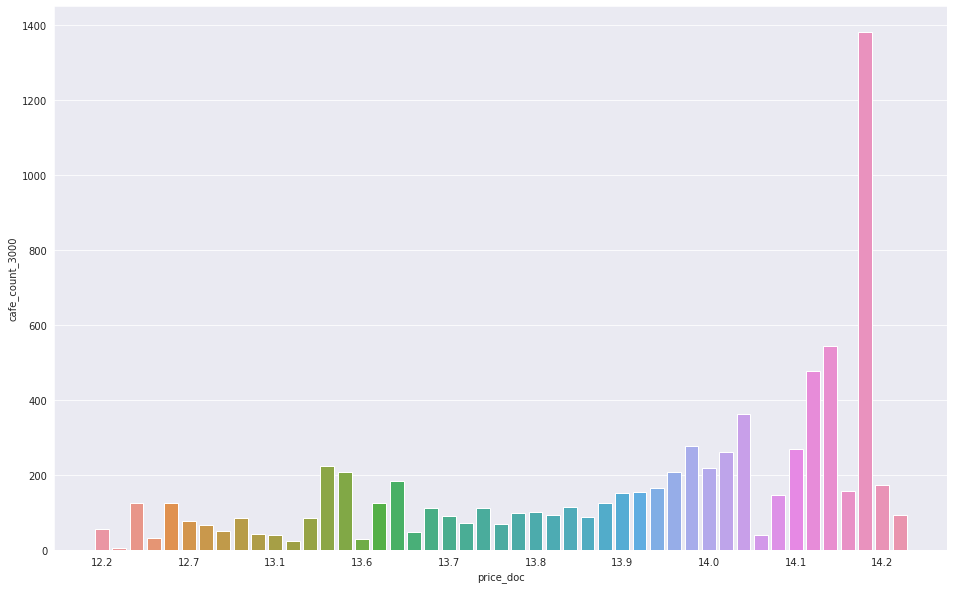

In [65]:
plt.figure(figsize=(16,10))
sns.barplot(x='price_doc',y='cafe_count_3000', data=i)
plt.locator_params(nbins=10)

In [6]:
dff= df.toPandas()

In [8]:
dff1 = dff[['price_doc','year']]

In [9]:
dff1.head(5)

,price_doc,year
0,5850000,2011
1,2000000,2011
2,8200000,2011
3,6000000,2011
4,1050000,2011
